# **Assignment 2: Process an image by transformations**

## **1. Libraries**

In [8]:
#from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [44]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Utility function

In [10]:
def show_image(image, title, figsize=None):
  if figsize is not None:
    plt.figure(figsize=figsize)
  else:
    plt.figure()
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

Sample image

In [11]:
image_file = '/content/gdrive/MyDrive/data.png'

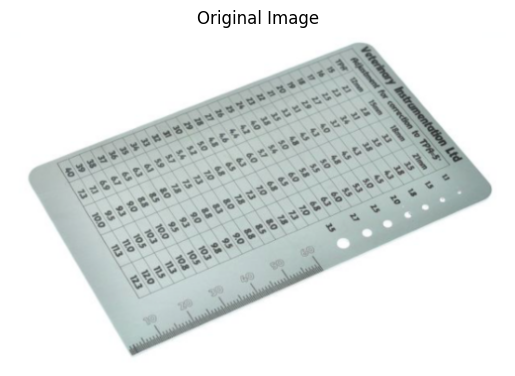

In [12]:
image_original = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)

show_image(image_original, "Original Image")

## **2. Idea**

First, let's try to detect 4 corners of the table. To do this, I will use Sobel filter to detect edges, then use Hough transform to detect lines. After that, I will use the lines to find the corners.

####  **2.1. Use Sobel derivative**

Sobel matrix takes the form:

$$
H_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

and:

$$
H_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

In [13]:
# sobel derivative

# 1. Create sobel kernel with 2D matrix
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


Define convolution function

In [14]:
def convolve2D(image, kernel):
    # Get the dimensions of the image and the kernel
    print(image.shape)
    i_h, i_w, _ = image.shape
    k_h, k_w = kernel.shape

    # Compute the output dimensions
    o_h = i_h - k_h + 1
    o_w = i_w - k_w + 1

    # Initialize the output array
    output = np.zeros((o_h, o_w))

    # Apply the kernel to the image
    for y in range(o_h):
        for x in range(o_w):
            output[y][x] = np.sum(image[y:y+k_h, x:x+k_w] * kernel)

    return output

In [15]:
img = image_original

In [16]:
derivative_x = convolve2D(img, sobel_kernel_x)
derivative_y = convolve2D(img, sobel_kernel_y)

(359, 533, 3)
(359, 533, 3)


Calculate gradient magnitude

In [17]:
gradient_magnitude = np.sqrt(np.square(derivative_x) + np.square(derivative_y))

Draw gradient magnitude image

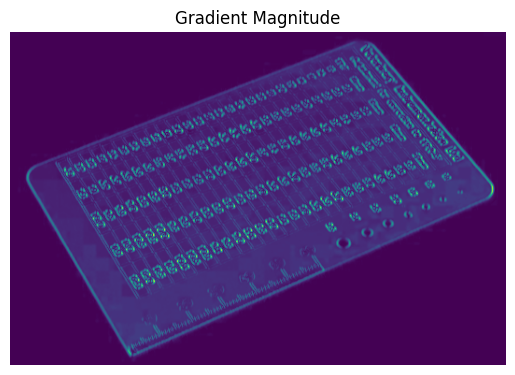

In [18]:
show_image(gradient_magnitude, "Gradient Magnitude")

Filter out points with gradient magnitude less than 0

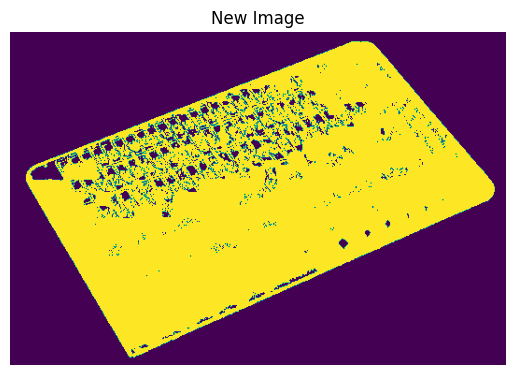

In [19]:
new_image = np.where(gradient_magnitude > np.mean(gradient_magnitude), 1, 0)

show_image(new_image, "New Image")

Basically, the image is now a binary image with 0 and 1. We also unction to attach points to the image

In [20]:
def show_image_with_point(image, title, X_cor, Y_cor, figsize=None):
  if figsize is not None:
    plt.figure(figsize=figsize)
  else:
    plt.figure()
  corner_img = image.copy()
  plt.imshow(image)
  plt.axis("off")
  for i in range(len(X_cor)):
    plt.plot(X_cor[i], Y_cor[i], marker='o', color = 'blue')
    #corner_img[Y_cor[i]][X_cor[i]] = 2
  plt.title(title)

  return corner_img

### **2.2. Find corners**

Algorithm:
- Since we have a binary image with 0 and 1 values, we can easily find the corners by finding the edges points.
- How to?
    -> Greedy from every columns and rows, the first point with value 1 is the edge point.

In [21]:
X_min = [] # store X coordinate of 4 corners
Y_min = [] # store Y coordinate of 4 corners
min_range_X = new_image.shape[1] # store minimum range of X coordinate
min_range_Y = new_image.shape[0] # store minimum range of Y coordinate

# left corner
min_range_X = new_image.shape[1]
for i in range(new_image.shape[0]):
    flag = 0
    while flag < new_image.shape[1] and new_image[i][flag] == 0:
        flag += 1

    if(flag <= min_range_X):
        Y = i
        min_range_X = flag
        X = flag

X_min.append(X)
Y_min.append(Y)


min_range_X = new_image.shape[1]
# right corner
for i in range(new_image.shape[0]):
    flag = new_image.shape[1] - 1
    while flag >= 0 and new_image[i][flag] == 0:
        flag -= 1

    # print(flag, min_range)
    if(new_image.shape[1] - flag <= min_range_X):
        Y = i
        min_range_X = new_image.shape[1] - flag
        X = flag

X_min.append(X)
Y_min.append(Y)


X_test = []
Y_test = []
min_range_Y = 0
# down corner
for i in range(new_image.shape[1]):
    flag = new_image.shape[0] - 1
    while flag >= 0 and new_image[flag][i] == 0:
        flag -= 1

    X_test.append(i)
    Y_test.append(flag)

    # print(flag, min_range_Y)
    if(flag >= min_range_Y):
        Y = flag
        min_range_Y = flag
        X = i

X_min.append(X)
Y_min.append(Y)

min_range_Y = new_image.shape[0]
# up corner
for i in range(new_image.shape[1]):
    flag = 0
    while flag < new_image.shape[0] and new_image[flag][i] == 0:
        flag += 1

    # print(flag, min_range)
    if(flag <= min_range_Y):
        Y = flag
        min_range_Y = flag
        X = i

X_min.append(X)
Y_min.append(Y)

print(X_min, Y_min)

[17, 518, 133, 383] [160, 171, 348, 11]


In [22]:
note_img = new_image.copy()

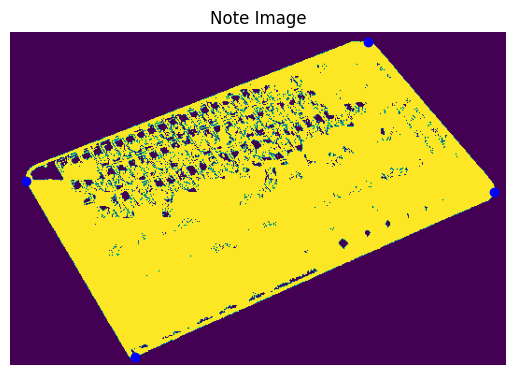

In [23]:
note_img = show_image_with_point(note_img, "Note Image", X_min, Y_min)

-> We detected correctly 4 corners of the table.

## **3. Forward transform**

To do forward transform, we need coordinate of 4 corners and the size of the output image.

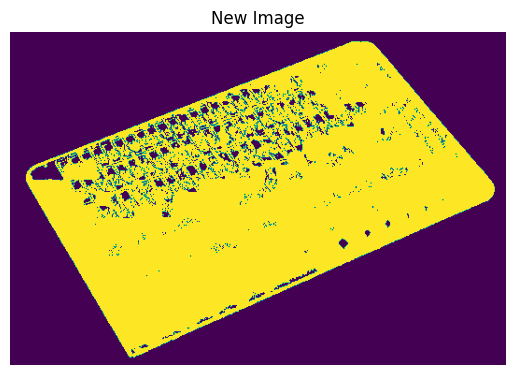

In [25]:
show_image(new_image, "New Image")

In [26]:
img.shape

(359, 533, 3)

In [27]:
X_min, Y_min

([17, 518, 133, 383], [160, 171, 348, 11])

Let's detect 2 out of 4 edges of the table. I will use the same method as above.

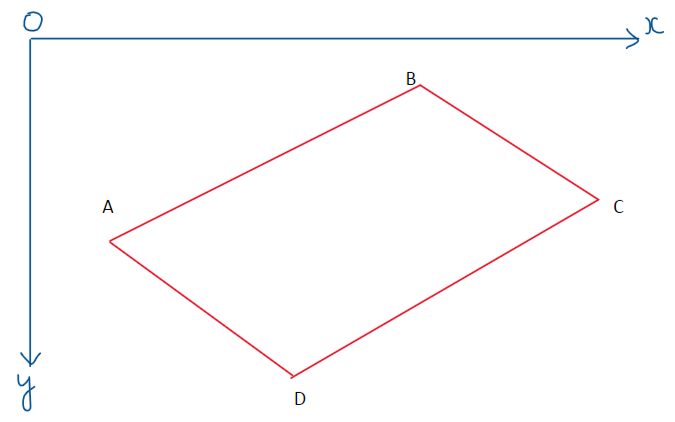

In [28]:
# find corners
X_set = []
Y_set = []

# 4 edges
AB = []
BC = []
CD = []
DA = []

# left
for i in range(X_min[0], X_min[3], 1):
    flag = 0
    while flag < new_image.shape[0] and new_image[flag][i] == 0:
        flag += 1

    #print(flag, new_image.shape[0])
    AB.append((i,flag))

# right
for i in range(X_min[3], X_min[1], 1):
    flag = 0
    while flag < new_image.shape[0] and new_image[flag][i] == 0:
        flag += 1

    BC.append((i,flag))

Extract X and Y coordinates of the edges

In [29]:
# get first value for each pair of AB
AB_x = [x[0] for x in AB]
AB_y = [x[1] for x in AB]

We will test our algorithm

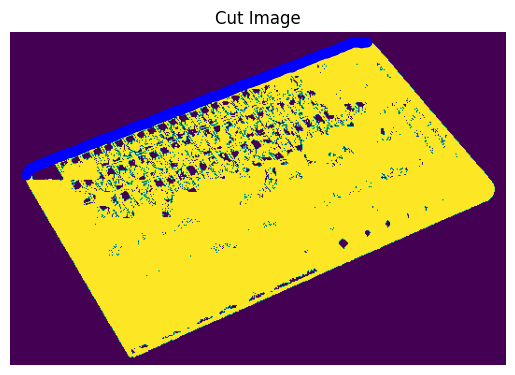

In [30]:
cut_img = show_image_with_point(new_image, "Cut Image", AB_x, AB_y)

-> Works perfectly

In [31]:
disAB = len(AB)
disBC = len(BC)
print(disAB, disBC)

366 135


Here, I will create by hand a function to get the transformation matrix

In [32]:
import numpy as np
import cv2

def getPerspectiveTransformHand(sourcePoints, destinationPoints):
    """
    Calculates the 3x3 matrix to transform the four source points to the four destination points

    Comment copied from OpenCV:
    /* Calculates coefficients of perspective transformation
    * which maps soruce (xi,yi) to destination (ui,vi), (i=1,2,3,4):
    *
    *      c00*xi + c01*yi + c02
    * ui = ---------------------
    *      c20*xi + c21*yi + c22
    *
    *      c10*xi + c11*yi + c12
    * vi = ---------------------
    *      c20*xi + c21*yi + c22
    *
    * Coefficients are calculated by solving linear system:
    *             a                         x    b
    * / x0 y0  1  0  0  0 -x0*u0 -y0*u0 \ /c00\ /u0\
    * | x1 y1  1  0  0  0 -x1*u1 -y1*u1 | |c01| |u1|
    * | x2 y2  1  0  0  0 -x2*u2 -y2*u2 | |c02| |u2|
    * | x3 y3  1  0  0  0 -x3*u3 -y3*u3 |.|c10|=|u3|,
    * |  0  0  0 x0 y0  1 -x0*v0 -y0*v0 | |c11| |v0|
    * |  0  0  0 x1 y1  1 -x1*v1 -y1*v1 | |c12| |v1|
    * |  0  0  0 x2 y2  1 -x2*v2 -y2*v2 | |c20| |v2|
    * \  0  0  0 x3 y3  1 -x3*v3 -y3*v3 / \c21/ \v3/
    *
    * where:
    *   cij - matrix coefficients, c22 = 1
    */

    """
    if sourcePoints.shape != (4,2) or destinationPoints.shape != (4,2):
        raise ValueError("There must be four source points and four destination points")

    a = np.zeros((8, 8))
    b = np.zeros((8))
    for i in range(4):
        a[i][0] = a[i+4][3] = sourcePoints[i][0]
        a[i][1] = a[i+4][4] = sourcePoints[i][1]
        a[i][2] = a[i+4][5] = 1
        a[i][3] = a[i][4] = a[i][5] = 0
        a[i+4][0] = a[i+4][1] = a[i+4][2] = 0
        a[i][6] = -sourcePoints[i][0]*destinationPoints[i][0]
        a[i][7] = -sourcePoints[i][1]*destinationPoints[i][0]
        a[i+4][6] = -sourcePoints[i][0]*destinationPoints[i][1]
        a[i+4][7] = -sourcePoints[i][1]*destinationPoints[i][1]
        b[i] = destinationPoints[i][0]
        b[i+4] = destinationPoints[i][1]

    x = np.linalg.solve(a, b)
    x.resize((9,), refcheck=False)
    x[8] = 1 # Set c22 to 1 as indicated in comment above
    return x.reshape((3,3))

In [33]:
# corners is X_min, Y_min coordinates
sourceCorners = np.array([[X_min[3], Y_min[3]],[X_min[0], Y_min[0]],[X_min[2], Y_min[2]],[X_min[1], Y_min[1]]])
destinationCorners = np.array([[0,0],[0,disAB],[disBC,disAB],[disBC,0]])

print("source:\n", sourceCorners)               # source: 4 corners of the original image
print("destination:\n", destinationCorners)     # destination: 4 corners of the new image

source:
 [[383  11]
 [ 17 160]
 [133 348]
 [518 171]]
destination:
 [[  0   0]
 [  0 366]
 [135 366]
 [135   0]]


Get transformation matrix

In [34]:
perspectiveTransformHand = getPerspectiveTransformHand(sourceCorners, destinationCorners)
print("Perspective transform by hand:\n", perspectiveTransformHand) # transform matrix

Perspective transform by hand:
 [[ 2.74711396e-01  6.74794436e-01 -1.12637203e+02]
 [-8.05340959e-01  6.79506434e-01  3.00971016e+02]
 [-2.62855582e-05  5.15109261e-04  1.00000000e+00]]


Define helper function to get the output image

In [35]:
def transform_image_forward(image_ori, transform_matrix):
    image_after_transform = np.zeros_like(image_ori)
    for i in range(image_ori.shape[0]):
        for j in range(image_ori.shape[1]):
            # location after transform
            a = np.array([i,j,1])
            location_after = transform_matrix@a
            location_after_y  = int((location_after[0]/location_after[2]))
            location_after_x  = int((location_after[1]/location_after[2]))
            if (location_after_y < image_after_transform.shape[0] and location_after_x < image_after_transform.shape[1] and location_after_x >= 0 and location_after_y >= 0):
                image_after_transform[location_after_y,location_after_x,:] = image_ori[i,j,:]
    return image_after_transform

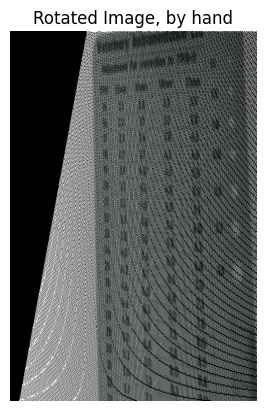

In [36]:
transformed_img = transform_image_forward(image_original, np.linalg.inv(perspectiveTransformHand))

transformed_img = np.array(transformed_img, dtype='uint8')

# scale image
transformed_img = cv2.resize(transformed_img, (1000, 1500), interpolation=cv2.INTER_AREA)

show_image(transformed_img, "Rotated Image, by hand")

-> We can recognize the hole effect here

## **4. Backward transform**

We define the backward transform function

First, the bilinear interpolation function

In [37]:
import numpy as np
def bilinear_interpolation(image, x, y):
    """Performs bilinear interpolation on an image at a given point.

    Args:
      image: A numpy array representing the image.
      x: The x-coordinate of the point to interpolate.
      y: The y-coordinate of the point to interpolate.

    Returns:
      A numpy array representing the interpolated value.
    """

    # Get the four nearest pixels to the point to interpolate.
    y_max, x_max, _ = image.shape
    x0 = int(np.floor(x))
    x1 = int(np.ceil(x))
    y0 = int(np.floor(y))
    y1 = int(np.ceil(y))
    if x0 < 0:
      x0 = 0
    if x1 > x_max - 1:
      x1 = x_max - 1
    if y0 < 0:
      y0 = 0
    if y1 > y_max - 1:
      y1 = y_max - 1

    # Calculate the weights for each pixel.
    wx = x - x0
    wy = y - y0

    # Calculate the interpolated value.
    interpolated_value = (1 - wx) * (1 - wy) * image[y0, x0] + wx * (1 - wy) * image[y0, x1] + (1 - wx) * wy * image[y1, x0] + wx * wy * image[y1, x1]

    return interpolated_value


In [38]:
def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]

    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]

    return img

In [39]:
def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = bilinear_interpolation(mtr,j,i)

    return to_img(dst)

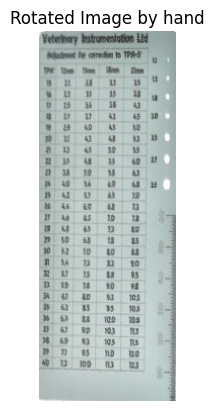

In [40]:
transformed_img = warpPerspective(image_original, perspectiveTransformHand, (disBC,disAB))

transformed_img = np.array(transformed_img, dtype='uint8')

show_image(transformed_img, "Rotated Image by hand")

-> The result is better now

In [41]:
sourceCorners = np.float32([[X_min[3], Y_min[3]],[X_min[0], Y_min[0]],[X_min[2], Y_min[2]],[X_min[1], Y_min[1]]])
destinationCorners = np.float32([[0,0],[0,disAB],[disBC,disAB],[disBC,0]])
perspectiveTransform = cv2.getPerspectiveTransform(sourceCorners, destinationCorners)
print("Perspective transform by lib:\n", perspectiveTransform)

Perspective transform by lib:
 [[ 2.74711396e-01  6.74794436e-01 -1.12637203e+02]
 [-8.05340959e-01  6.79506434e-01  3.00971016e+02]
 [-2.62855582e-05  5.15109261e-04  1.00000000e+00]]


-> Which proves that our algorithm is correctly implemented.

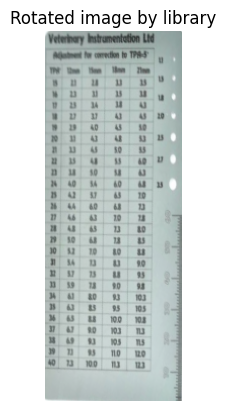

In [42]:
img_output = cv2.warpPerspective(img, perspectiveTransform, (disBC, disAB))

show_image(img_output, "Rotated image by library")

## **6. Try with other images**

In [46]:
cvbook = cv2.imread('/content/gdrive/MyDrive/cvbook.jpg')
# convert image to RGB color for matplotlib
cvbook = cv2.cvtColor(cvbook, cv2.COLOR_BGR2RGB)

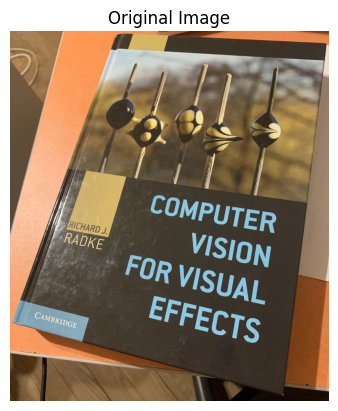

In [47]:
show_image(cvbook, "Original Image")

Points in this figure are detected before transformation

In [48]:
original_points = np.float32([[241,6],[726,29],[6,668],[627,837]])
destination_size = (300, 400)

r,c = destination_size
transformed_points = np.float32([[0,0],[r,0],[0,c],[r,c]])

array([[[162, 125,  81],
        [160, 123,  79],
        [157, 120,  76],
        ...,
        [120,  61,  29],
        [119,  60,  28],
        [119,  60,  28]],

       [[163, 126,  82],
        [161, 124,  80],
        [159, 122,  78],
        ...,
        [125,  60,  28],
        [125,  60,  28],
        [124,  59,  27]],

       [[165, 128,  84],
        [163, 126,  82],
        [161, 124,  80],
        ...,
        [132,  63,  32],
        [132,  63,  32],
        [132,  63,  32]],

       ...,

       [[ 70,  46,  12],
        [ 69,  45,  11],
        [ 69,  45,  11],
        ...,
        [ 29,  12,   5],
        [ 33,  16,   9],
        [ 32,  15,   7]],

       [[ 71,  47,  13],
        [ 70,  46,  12],
        [ 71,  47,  13],
        ...,
        [ 27,   9,   5],
        [ 31,  13,   9],
        [ 32,  15,   8]],

       [[ 72,  45,  15],
        [ 73,  46,  16],
        [ 82,  55,  25],
        ...,
        [ 24,  10,   0],
        [ 28,  14,   3],
        [ 36,  19,   9]]

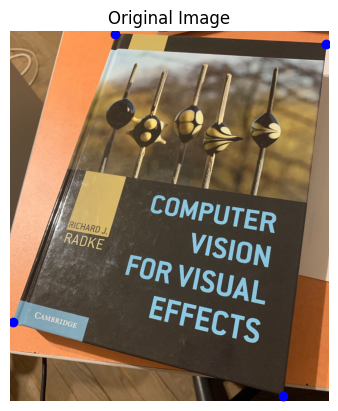

In [49]:
show_image_with_point(cvbook, "Original Image", original_points[:,0], original_points[:,1])

In [50]:
transform_matrix = getPerspectiveTransformHand(original_points, transformed_points)

print("Perspective transform by hand:\n", transform_matrix)

Perspective transform by hand:
 [[ 7.53496708e-01  2.67479949e-01 -1.83197586e+02]
 [-3.99227991e-02  8.41850329e-01  4.57029261e+00]
 [ 3.03922821e-04  6.21097907e-04  1.00000000e+00]]


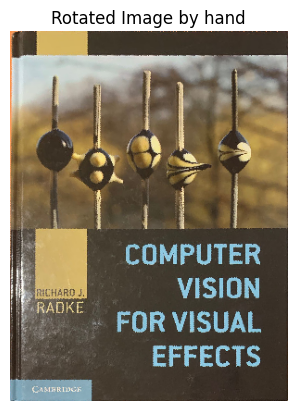

In [51]:
cvbook_rotated = warpPerspective(cvbook, transform_matrix, destination_size)

show_image(cvbook_rotated, "Rotated Image by hand")

Looks good!